In [12]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 350)

# Import Data

In [4]:
loan = pd.read_csv('./dataset/loan/loan_table.csv')

In [5]:
loan.head()

,loan_id,loan_purpose,date,loan_granted,loan_repaid
0,19454,investment,2012-03-15,0,NaN
1,496811,investment,2012-01-17,0,NaN
2,929493,other,2012-02-09,0,NaN
3,580653,other,2012-06-27,1,1.0
4,172419,business,2012-05-21,1,0.0


In [13]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101100 entries, 0 to 101099
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   loan_id       101100 non-null  int64  
 1   loan_purpose  101100 non-null  object 
 2   date          101100 non-null  object 
 3   loan_granted  101100 non-null  int64  
 4   loan_repaid   47654 non-null   float64
dtypes: float64(1), int64(2), object(2)
memory usage: 3.9+ MB


In [6]:
loan.shape

(101100, 5)

In [7]:
borrower = pd.read_csv('./dataset/loan/borrower_table.csv')

borrower.head()

In [14]:
borrower.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101100 entries, 0 to 101099
Data columns (total 12 columns):
 #   Column                                           Non-Null Count   Dtype  
---  ------                                           --------------   -----  
 0   loan_id                                          101100 non-null  int64  
 1   is_first_loan                                    101100 non-null  int64  
 2   fully_repaid_previous_loans                      46153 non-null   float64
 3   currently_repaying_other_loans                   46153 non-null   float64
 4   total_credit_card_limit                          101100 non-null  int64  
 5   avg_percentage_credit_card_limit_used_last_year  94128 non-null   float64
 6   saving_amount                                    101100 non-null  int64  
 7   checking_amount                                  101100 non-null  int64  
 8   is_employed                                      101100 non-null  int64  
 9   yearly_salary  

# Data Pre-Processing

In [10]:
borrower.shape

(101100, 12)

The dataset has a lot of NAs. As a first step, we will need to deal with them. The general rule on how to deal with NAs is to firstly find out if they are random or they actually happen based on some rule. If they are random, we can either remove those rows or impute them (mean, median, etc.). On the other hand, if they do happen for a reason, we need to replace them with a specific value such that we don’t lose that information.

The second scenario is way more common when dealing with consumer data.

In [15]:
data=pd.merge(borrower, loan)

In [16]:
data.head()

,loan_id,is_first_loan,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,...,dependent_number,loan_purpose,date,loan_granted,loan_repaid
0,289774,1,NaN,NaN,8000,...,3,business,2012-01-31,0,NaN
1,482590,0,1.0,0.0,4500,...,1,investment,2012-11-02,0,NaN
2,135565,1,NaN,NaN,6900,...,8,other,2012-07-16,1,1.0
3,207797,0,1.0,0.0,1200,...,1,investment,2012-06-05,0,NaN
4,828078,0,0.0,0.0,6900,...,1,emergency_funds,2012-11-28,0,NaN


In [17]:
# let's count NAs per column
print(data.isnull().sum().sort_values())

loan_id                                                0
is_first_loan                                          0
total_credit_card_limit                                0
saving_amount                                          0
checking_amount                                        0
is_employed                                            0
yearly_salary                                          0
age                                                    0
dependent_number                                       0
loan_purpose                                           0
date                                                   0
loan_granted                                           0
avg_percentage_credit_card_limit_used_last_year     6972
loan_repaid                                        53446
fully_repaid_previous_loans                        54947
currently_repaying_other_loans                     54947
dtype: int64


“fully_repaid_previous_loans” and “currently_repaying_other_loans” have the same number of NAs. These would make sense if they exactly match the number of people who never got any other loans. Let’s see:


In [20]:
(data.fully_repaid_previous_loans.isnull() == (data.is_first_loan == 1)).value_counts()

True    101100
dtype: int64

In [21]:
print((data.currently_repaying_other_loans.isnull()==(data.is_first_loan == 1)).value_counts())

True    101100
dtype: int64


Yes, they match exactly. We can just replace those NAs with -1

In [22]:
data.fully_repaid_previous_loans.fillna(-1, inplace=True) 
data.currently_repaying_other_loans.fillna(-1, inplace=True) 

In [32]:
#print(data[data['is_first_loan'] == 1]['fully_repaid_previous_loans'].unique())
#print(data[data['is_first_loan'] == 1]['currently_repaying_other_loans'].unique())

At this point, we don't really need the variable is_first_loan since its information is already inside other variables via the -1 flag

In [23]:
del data['is_first_loan']

“Loan repaid” as NA would make sense if the loan was not granted in the first place. Let’s check:

In [24]:
print((data.loan_repaid.isnull()==(data.loan_granted == 0)).value_counts())

True    101100
dtype: int64


In [25]:
data.loan_repaid.fillna(-1, inplace=True) 

Finally, “avg_percentage_credit_card_limit_used_last_year” NA could simply mean that that person doesn’t have a credit card. Let’s see:


In [26]:
print((data.avg_percentage_credit_card_limit_used_last_year.isnull()==(data.total_credit_card_limit == 0)).value_counts())

True    101100
dtype: int64


Yes, they match exactly. Even in this case, we can just replace it with -1.

In [27]:
#let's change the column name with something shorter:
data.rename(columns = {'avg_percentage_credit_card_limit_used_last_year':'pct_credit_card'}, inplace = True)
#And replace the NAs
data.pct_credit_card.fillna(-1, inplace=True) 

In [28]:
print(data.isnull().sum().max())

0


In [29]:
print(data.isnull().sum().sort_values())

loan_id                           0
fully_repaid_previous_loans       0
currently_repaying_other_loans    0
total_credit_card_limit           0
pct_credit_card                   0
saving_amount                     0
checking_amount                   0
is_employed                       0
yearly_salary                     0
age                               0
dependent_number                  0
loan_purpose                      0
date                              0
loan_granted                      0
loan_repaid                       0
dtype: int64


There are no more NA

In [30]:
data.head()

,loan_id,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,pct_credit_card,...,dependent_number,loan_purpose,date,loan_granted,loan_repaid
0,289774,-1.0,-1.0,8000,0.49,...,3,business,2012-01-31,0,-1.0
1,482590,1.0,0.0,4500,1.03,...,1,investment,2012-11-02,0,-1.0
2,135565,-1.0,-1.0,6900,0.82,...,8,other,2012-07-16,1,1.0
3,207797,1.0,0.0,1200,0.82,...,1,investment,2012-06-05,0,-1.0
4,828078,0.0,0.0,6900,0.80,...,1,emergency_funds,2012-11-28,0,-1.0


In [33]:
data.describe()

,loan_id,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,pct_credit_card,...,yearly_salary,age,dependent_number,loan_granted,loan_repaid
count,101100.000000,101100.000000,101100.000000,101100.000000,101100.000000,...,101100.000000,101100.000000,101100.000000,101100.000000,101100.000000
mean,499666.826726,-0.132957,-0.377171,4112.743818,0.605241,...,21020.727992,41.491632,3.864748,0.471355,-0.224926
std,288662.006929,0.967656,0.753366,2129.121462,0.472484,...,18937.581415,12.825570,2.635491,0.499181,0.884183
min,30.000000,-1.000000,-1.000000,0.000000,-1.000000,...,0.000000,18.000000,0.000000,0.000000,-1.000000
25%,250333.750000,-1.000000,-1.000000,2700.000000,0.560000,...,0.000000,32.000000,2.000000,0.000000,-1.000000
50%,499885.000000,-1.000000,-1.000000,4100.000000,0.710000,...,21500.000000,41.000000,3.000000,0.000000,-1.000000
75%,749706.250000,1.000000,0.000000,5500.000000,0.850000,...,35300.000000,50.000000,6.000000,1.000000,1.000000
max,999987.000000,1.000000,1.000000,13500.000000,1.090000,...,97200.000000,79.000000,8.000000,1.000000,1.000000


Let’s now build the model. We will use a random forest here. RF should work well with these kinds of data, especially because these variables appear to be obviously correlated with each other. After all, they are pretty much all proxies for the economic situation of the person asking for the loan. And RF can deal extremely well with correlated variables. Also, RF works well in high dimensions and requires minimum time to be optimized.

At first, we will focus only on the loans that were granted by the bank. For these events, we know exactly whether the loan was repaid or not, and therefore we can evaluate our model accuracy. After this step, we will also take into account the loans that were not granted by the bank.

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.model_selection import train_test_split
from pdpbox import pdp, info_plots
np.random.seed(1234)
  
#Let's extract week of the year from the date to get a sense of yearly trends
data['date_week'] = pd.to_datetime(data.date).dt.week
  
#We don't need these two columns in the model
del data['loan_id'] 
del data['date'] 
  
#Let's only consider loans that were granted for now
data_granted = data.query('loan_granted == 1')
del data_granted['loan_granted']

In [35]:
#make dummies
data_granted_d = pd.get_dummies(data_granted, drop_first=True)
  
#Split the dataset and build the model. We will use standard RF params here. With more time we would optimize them more, although we don't expect the standard params to be far off from the optimal ones (after all, that's one of the main RF strengths)
train, test = train_test_split(data_granted_d, test_size = 0.34)
      
#build the model
rf = RandomForestClassifier(n_estimators=100, max_features=7, oob_score=True)
rf.fit(train.drop('loan_repaid', axis=1), train['loan_repaid'])
  
#let's print OOB accuracy and confusion matrix
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=7, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=True, random_state=None, verbose=0, warm_start=False)
print(
"OOB accuracy is", 
rf.oob_score_, 
"\n", 
"OOB Confusion Matrix", 
"\n",
pd.DataFrame(confusion_matrix(train['loan_repaid'], rf.oob_decision_function_[:,1].round(), labels=[0, 1]))
)

OOB accuracy is 0.9171727449047725 
 OOB Confusion Matrix 
        0      1
0  10138   1061
1   1544  18708


In [36]:
#and let's print test accuracy and confusion matrix
print(
"Test accuracy is", rf.score(test.drop('loan_repaid', axis=1),test['loan_repaid']), 
"\n", 
"Test Set Confusion Matrix", 
"\n",
pd.DataFrame(confusion_matrix(test['loan_repaid'], rf.predict(test.drop('loan_repaid', axis=1)), labels=[0, 1]))
)

Test accuracy is 0.9186570388199716 
 Test Set Confusion Matrix 
       0     1
0  5194   555
1   763  9691


So, OOB error and test error are pretty similar around 8%. We are confident we are not overfitting. Overall, the confusion matrix looks good too, with class errors below 10%. If we cared about the very best possible accuracy or specifically minimizing false positives or false negatives, we would find the best cut-off point. In this case, that doesn’t appear to be too important. The cost of a false positive is the same as false negative and, overall, the model seems to be doing already pretty well. Therefore, we are fine using the default 0.5 cut-off point. With more time though, we would definitely look into the ROC and identify the very best possible cut-off point.

Let’s now check how our model compares to the bank in terms of profitability:

In [37]:
#Bank profits
bank_score = (data_granted.loan_repaid==1).sum()-(data_granted.loan_repaid==0).sum()


In [38]:
#Our profits. We will feed the entire dataset into our model and use the check predictions vs actual data to estimate the profits
predictions = rf.predict(data_granted_d.drop('loan_repaid', axis=1))
our_score = ((predictions == 1) & (data_granted_d['loan_repaid'] == 1)).sum() - ((predictions == 1) & (data_granted['loan_repaid'] == 0)).sum()

In [39]:
print("Our score on people who had got the loan is:", our_score, "\n", "The bank score is:", bank_score)

Our score on people who had got the loan is: 29388 
 The bank score is: 13758


However, in this score we are somehow assuming that we are not giving the loan to people who hadn’t got the loan from the bank. Firstly, this is unrealistic: in future we will not know who is receiving a loan from the bank. And secondly, it is probably sub-optimal: there are likely many people who haven’t got the loan that might be able to repay it.
So let’s try to estimate profits from giving a loan to those people too. This is a bit harder because we don’t have a label. Our approach is the following: We will use our model to decide who should receive a loan among people who hadn’t got it from the bank To estimate profits from those people, we will use our model precision. Let’s say that from the confusion matrix, we know that if we predict class 1, our model is right ~95% of the times. So, we can assume a similar score on the group of people who hadn’t got the loan. I.e. if we predict class 1 for 100 people, we can assume our profits will be 95 - 5 = 90.

In [44]:
#we will use our test set to estimate our model precision
precision = precision_score(test['loan_repaid'], rf.predict(test.drop('loan_repaid', axis=1)))
 
#get the predictions
data_non_granted = data.query('loan_granted == 0')
del data_non_granted['loan_granted']
data_non_granted_d = pd.get_dummies(data_non_granted, drop_first=True)
predictions_non_granted = rf.predict(data_non_granted_d.drop('loan_repaid', axis=1))
 
#use precision to estimate who will repay it and, therefore, final profits
profits_non_granted = ((predictions_non_granted==1).sum() * precision - (predictions_non_granted==1).sum() * (1-precision)).round()
 
#These are the final scores. Obviously, bank profits are same as before
print("Our score is:", our_score+profits_non_granted, "\n", "The bank score is:", bank_score)

Our score is: 46100.0 
 The bank score is: 13758


Overall, there are a few assumptions made along the way that probably made our score a bit higher than what we will get once we put this model into production. For instance, we tested and trained on the bank data. This gave us an advantage over the bank, whose model had to be built previously in order to choose who should receive the loan. We also assumed that our model will perform similarly when applied to fairly different datasets: people who had got the loan and people who had not.

That being said, at this stage, our goal is not to have a 100% accurate picture of what will happen once we put the model into production. Only experimentation can do that. Our goal here is to get a realistic estimate of what might happen, to decide if it makes sense to do the experiment. And our results are reliable enough to answer that question.

Describe the impact of the most important variables on the prediction. Also, focus on the variable “is_employed”, which describes whether the borrower is employed when she asks for the loan. How does this variable impact the model?

Regarding the impact of the most important variables, it is the usual stuff. Build partial dependence plots for each variable and describe them, focusing on how a change in a given variable value impacts the prediction. We will just do for one variable as an example.

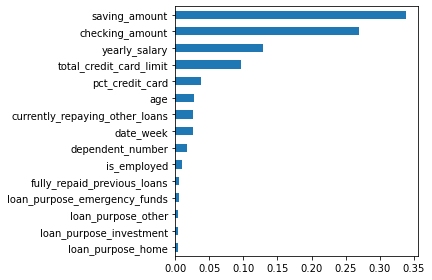

In [45]:
#Let's plot variable importance 
feat_importances = pd.Series(rf.feature_importances_, index=train.drop('loan_repaid', axis=1).columns)
feat_importances.sort_values().plot(kind='barh')

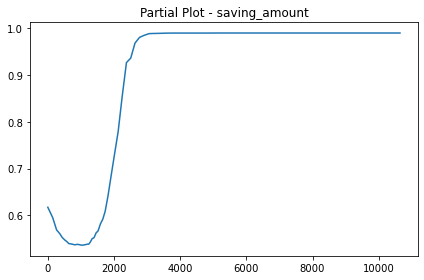

In [46]:
#saving_amount
pdp_iso = pdp.pdp_isolate(model=rf, 
                          dataset=train.drop('loan_repaid', axis=1),      
                          model_features=list(train.drop('loan_repaid', axis=1)), 
                          feature='saving_amount', 
                          num_grid_points=50)
pdp_dataset = pd.Series(pdp_iso.pdp, index=pdp_iso.feature_grids)
pdp_dataset.plot(title='Partial Plot - saving_amount')

The spike close to the origin is likely noise. There are very few people in the dataset with close to 0 saving amount. Except for that, the plot is very interesting. It looks like there are two clear segments: if saving amounts are below 2K, then probability of paying back the loan is way lower. After 2K, the probability goes up significantly. Also, once saving amounts are large enough, the curve flattens. This means that, in order to repay a loan, it is important to have at least X money in your saving account, but once you are above that threshold, it doesn’t really matter anymore. Whether you have 3K or 8K, the probability is the same.

Let’s now focus on the second part of the question: the impact of is_employed. We can see from the variable importance plot that that variable is barely used by the model. You can double check this by removing it from the dataset and rebuilding the RF. You will get pretty much the same exact score for accuracy, precision, etc.

However, being employed taken by itself must be important. We can see that the proportion of people who pay back the loan is significantly different once we segment by is_employed.

In [47]:
print(data_granted.groupby('is_employed')['loan_repaid'].mean().reset_index(name ='proportion_loan_repaid'))

   is_employed  proportion_loan_repaid
0            0                0.179428
1            1                0.690431


The reason is_employed appears not important is that it is highly correlated with a more informative variable: yearly_salary.

In [49]:
data.is_employed[0]

0

In [50]:
data.yearly_salary

0             0
1         13500
2         24500
3             0
4         18100
          ...  
101095        0
101096    36100
101097    40800
101098    41900
101099    44200
Name: yearly_salary, Length: 101100, dtype: int64

In [53]:
from scipy.stats import pearsonr

In [55]:
pearsonr(data.yearly_salary, data.is_employed)

(0.7990505464063629, 0.0)

In [56]:
print("Correlation between yearly_salary and is_employed is:", round(pearsonr(data.yearly_salary, data.is_employed)[0],2))

Correlation between yearly_salary and is_employed is: 0.8


# Conclusions

Yearly_salary variable has already all information within is_employed plus additional information. And RF is smart enough to not pick the same information twice. What we are proving here is that RF, and tree-based models more in general, can deal extremely well with correlated variables. This is not true for many other models, it is a huge pro of RF, and one of the main reasons tree-based models have become so popular.

Are there any other variables you’d like to include in the model?

Obviously, there are many other variables that can be included in the model to improve its performance. One thing to notice here is that all variables are essentially a snapshot of the economic situation of the person asking for the loan. However, the goal is not really understanding how that person is doing economically today. The goal should be to figure out how much money they will have in future to see if they are able to repay the loan.

It would be interesting to have variables that can help understand someone’s trajectory. Education could be an interesting one. A computer science student at a top school might not have a great economic situation today, but is very likely to be able to make a good amount of money in future. Also, having multiple snapshots at different times of the same variables we have in the models could be interesting. I.e. saving amount 1 yr ago, saving amount 2 yrs ago, etc. After all, just like for any other metrics, trend is the most important thing if we want to make a prediction.